# Sea Surface Salinity Bias - WOA23

This notebook plots the SSS bias of a model simulation vs. climatology derived from WOA23

In [1]:
import os
import datetime

In [2]:
config = {
    "startyr": "2003",
    "endyr": "2022",
    "dora_id": "odiv-384",
}

MAR will pass for environment variables to the script when running via the web engine:

* `MAR_STARTYR`: Beginning year of analysis from model
* `MAR_ENDYR`: Ending year of analysis from model
* `MAR_DORA_ID`: The experiment ID in the database
* `MAR_PATHPP`: The top-level path to the post-processing experiment directory of the experiment

The block below will use values passed in by Dora but default to the values defined above in `config`. This is useful for interactive usage and debugging.

If executed from Dora, there will also be a `DORA_EXECUTE` variable that is set.

In [3]:
for k, v in config.items():
    config[k] = (
        os.environ[f"MAR_{k.upper()}"]
        if f"MAR_{k.upper()}" in os.environ.keys()
        else v
    )

### Import Python Modules

In [4]:
import doralite
import glob
import momlevel
import subprocess

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from matplotlib.colors import ListedColormap, BoundaryNorm

In [5]:
# momgrid will use a directory of pre-computed weights that is used for calculating basic area-weighted statistics later
import momgrid
os.environ["MOMGRID_WEIGHTS_DIR"] = "/nbhome/John.Krasting/grid_weights"

### Definie Local Parameters

In [6]:
# Define some local variables. These are taken from the doralite object
# or they can be defined locally

experiment =  doralite.dora_metadata(config["dora_id"])
pathPP = experiment["pathPP"]
expName = experiment["expName"]

# Define start and end years
start = int(config["startyr"])
end = int(config["endyr"])

### Determine What Files to Load

In [7]:
# Determine what files are needed (leave this up to the developer for flexibility)
# This is an example of what someone might do:

component = "ocean_monthly"
static = f"{component}/{component}.static.nc"
varname = "*"

chunk = "monthly_5yr"
filelist = sorted(glob.glob(f"{pathPP}{component}/av/**/{chunk}/{component}.*.{varname}.nc", recursive=True))
print(f"{pathPP}{component}/av/**/{chunk}/{component}.*.{varname}.nc")
def is_in_range(file,start,end):
    start = int(start)
    end = int(end)
    target = set(list(range(start,end+1)))
    fname = os.path.basename(file)
    times = fname.split(".")[1]
    times = times.split("-")
    times = [int(x[0:4]) for x in times]
    candidate = set(list(range(times[0],times[1]+1)))
    return len(candidate.intersection(target)) > 0

filelist = [x for x in filelist if is_in_range(x,start,end)]
staticfile = f"{pathPP}/{static}"

_ = [print(x) for x in filelist]

/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20240508/om5_b04_fixICbug/gfdl.ncrc5-intel23-prod/pp/ocean_monthly/av/**/monthly_5yr/ocean_monthly.*.*.nc
/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20240508/om5_b04_fixICbug/gfdl.ncrc5-intel23-prod/pp/ocean_monthly/av/monthly_5yr/ocean_monthly.2003-2007.01.nc
/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20240508/om5_b04_fixICbug/gfdl.ncrc5-intel23-prod/pp/ocean_monthly/av/monthly_5yr/ocean_monthly.2003-2007.02.nc
/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20240508/om5_b04_fixICbug/gfdl.ncrc5-intel23-prod/pp/ocean_monthly/av/monthly_5yr/ocean_monthly.2003-2007.03.nc
/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20240508/om5_b04_fixICbug/gfdl.ncrc5-intel23-prod/pp/ocean_monthly/av/monthly_5yr/ocean_monthly.2003-2007.04.nc
/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20240508/om5_b04_fixICbug/gfdl.ncrc5-intel23-prod/pp/ocean_monthly/av/monthly_5yr/ocean_monthly.2003-2007.05.nc
/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20240

### DMgetting Files

Dora cannot issue calls to dmget

In [8]:
if not "DORA_EXECUTE" in os.environ.keys():
    print("Calling dmget on files ...")
    cmd = ["dmget"]+filelist+[staticfile]
    _ = subprocess.check_output(cmd)

Calling dmget on files ...


### Load model data and grid

In [9]:
ds = momgrid.Gridset(filelist, force_symmetric=True, return_corners=True)
model_type = ds.model
ds = ds.data.sel(time=slice(f"{str(start).zfill(4)}-01-01",f"{str(end).zfill(4)}-12-31"))

### Load observational data (if needed)

Note that Dora only mounts `/archive`, `/nbhome`, and `/home`

In [10]:

if "om5" in model_type:
    obs = xr.open_dataset("/archive/gold/datasets/OM5_025/INPUT/salt_restore_JRA_v20240410.nc",decode_times=False).sos.mean(dim='time')
elif "om4" in model_type:
    obs = xr.open_dataset("/archive/gold/datasets/OM4_025/INPUT.JRA.v2019.07.04/salt_restore_JRA.1440x1080.v20190706.nc",decode_times=False).sos.mean(dim='time')
obs=obs.rename({'i': 'xh','j': 'yh'})

# This could be used to compare to WOA instead of the restore file
# dsobs = xr.open_dataset("/net3/bgr/Datasets/WOA/woa23_decav_s00_01.nc",decode_times=False).isel(time=0)['s_an']
# import xesmf
# Regrid woa to the model grid
# woa = dsobs.isel(depth=0)
# RG = xr.Dataset()
# RG["yh"]=ds.yh.values
# RG["xh"]=ds.xh.values
# RG = RG.assign_coords(longitude=(('yh','xh'),ds['geolon'].values))
# RG = RG.assign_coords(latitude=(('yh','xh'),ds['geolat'].values))
# regridder_mod = xesmf.Regridder(woa,RG, "bilinear",periodic=True)
# obs = xr.Dataset()
# obs["yh"]=ds.yh.values
# obs["xh"]=ds.xh.values
# obs = obs.assign_coords(lon=(('yh','xh'),ds['geolon'].values))
# obs = obs.assign_coords(lat=(('yh','xh'),ds['geolat'].values))
# obs['sos']=(('yh','xh'),regridder_mod(woa.values))
# obs=obs.sos
# The woa18 data is also here /archive/jpk/datasets/OM5/obs/WOA18

In [11]:
# # This can be used to compare the woa and jra restoring SSS fields
# #Compare the woa and restore file:

# dsobs = xr.open_dataset("/net3/bgr/Datasets/WOA/woa23_decav_s00_01.nc",decode_times=False).isel(time=0)['s_an']
    
# import xesmf

# Regrid woa to the model grid

# woa = dsobs.isel(depth=0)

# RG = xr.Dataset()
# RG["yh"]=ds.yh.values
# RG["xh"]=ds.xh.values
# RG = RG.assign_coords(longitude=(('yh','xh'),ds['geolon'].values))
# RG = RG.assign_coords(latitude=(('yh','xh'),ds['geolat'].values))

# regridder_mod = xesmf.Regridder(woa,RG, "bilinear",periodic=True)

# obs = xr.Dataset()
# obs["yh"]=ds.yh.values
# obs["xh"]=ds.xh.values
# obs = obs.assign_coords(lon=(('yh','xh'),ds['geolon'].values))
# obs = obs.assign_coords(lat=(('yh','xh'),ds['geolat'].values))

# obs['sos']=(('yh','xh'),regridder_mod(woa.values))
# obs=obs.sos

# if "om5" in model_type:
#     obs2 = xr.open_dataset("/archive/gold/datasets/OM5_025/INPUT/salt_restore_JRA_v20240410.nc",decode_times=False).sos.mean(dim='time')
# elif "om4" in model_type:
#     obs2 = xr.open_dataset("/archive/gold/datasets/OM4_025/INPUT.JRA.v2019.07.04/salt_restore_JRA.1440x1080.v20190706.nc",decode_times=False).sos.mean(dim='time')
# obs2=obs2.rename({'i': 'xh','j': 'yh'})


# import cmocean
# import matplotlib as mpl
# import copy
# levels=np.linspace(25,37,49)

# cmap=copy.copy(cmocean.cm.haline)
# cmap.set_bad('gray')


# plt.figure()
# plt.pcolormesh(obs2.lon,obs2.lat,obs2,
#                cmap=cmap,
#                norm=mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False))
# plt.colorbar()

# plt.figure()
# plt.pcolormesh(obs.lon,obs.lat,obs,
#                cmap=cmap,
#                norm=mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False))
# plt.colorbar()

# cmap, norm, boundaries = gen_levs_and_cmap(-2,2.01,0.1)
# cmap.set_bad('gray')


# # Setup plot
# fig = plt.figure(figsize=(10,6))
# ax = plt.subplot(1,1,1, facecolor="lightgray")

# # Definie geolon and geolat for plotting (use corners!)
# x = ds.geolon_c
# y = ds.geolat_c

# # Get colormap
# cmap, norm, boundaries = gen_levs_and_cmap(-2,2.01,0.1)

# # Run pcolormesh
# cb = plt.pcolormesh(x,y,obs2-obs, cmap=cmap, norm=norm)

# # Add statistics
# stats, stats_str = calculate_stats(obs2, obs, ds.areacello)
# add_stats_box(ax, stats_str)

# # Add colorbar
# add_colorbar(fig, cb, boundaries)


# xrange = (-298,61)
# yrange = (60.,91.)

# _obs = momgrid.geoslice.geoslice(obs,x=xrange,y=yrange,xcoord='lon',ycoord='lat')
# _obs2 = momgrid.geoslice.geoslice(obs2,x=xrange,y=yrange,xcoord='lon',ycoord='lat')

# xq = list((_model.xh.values - 0.5).astype(int))
# yq = list((_model.yh.values - 0.5).astype(int))

# xq = xq + [xq[-1] + 1]
# yq = yq + [yq[-1] + 1]

# x = ds.geolon_c.values[yq,:][:,xq]
# y = ds.geolat_c.values[yq,:][:,xq]

# # Get colormap
# cmap, norm, boundaries = gen_levs_and_cmap(-2.0,2.125,0.125)

# fig = plt.figure(figsize=(6,6))
# ax = plt.subplot(1,1,1, facecolor="lightgray", projection=ccrs.NorthPolarStereo())
# cb = ax.pcolormesh(x,y,_obs2-_obs,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
# ax.coastlines()


# # Add statistics
# stats, stats_str = calculate_stats(_obs2, _obs, _model.areacello)
# add_stats_box(ax, stats_str, x=0.05, y=0.95)

# # Add colorbar
# add_colorbar(fig, cb, boundaries)



### Define some helper function for the plots

In [12]:
def gen_levs_and_cmap(start,end,delta,cmap="RdBu_r"):
    """Generates a difference colormap centered on white"""
    boundaries = np.arange(start,end,delta)
    levels = (boundaries[0:-1] + boundaries[1:]) / 2.
    base_cmap = plt.get_cmap(cmap)
    colors = base_cmap(np.linspace(0, 1, len(levels)))
    colors[[int(len(colors) / 2) - 1]] = [1, 1, 1, 1]
    colors[[int(len(colors) / 2)]] = [1, 1, 1, 1]
    cmap = ListedColormap(colors)
    norm = BoundaryNorm(boundaries, cmap.N, clip=True)
    return (cmap, norm, boundaries)

In [13]:
def set_annotaions(ax):
    _ = ax.set_xticks([])
    _ = ax.set_yticks([])
    _ = ax.text(0.0,1.06, "SSS Bias Relative to JRA restore file", weight="bold", fontsize=12, transform=ax.transAxes)
    _ = ax.text(0.0,1.02, expName, style="italic", fontsize=10, transform=ax.transAxes)
    _ = ax.text(1.0,1.05, str(starttime.values), ha="right", fontsize=8, transform=ax.transAxes)
    _ = ax.text(1.0,1.02, str(endtime.values), ha="right", fontsize=8, transform=ax.transAxes)

In [14]:
def add_stats_box(ax, stats_str, x=0.015, y=0.8):
        # Adding the text box annotation
    props = dict(
        boxstyle="round,pad=0.3", edgecolor="black", linewidth=1.5, facecolor="white"
    )
    ax.text(
        x,
        y,
        stats_str,
        transform=ax.transAxes,
        fontsize=8,
        verticalalignment="top",
        bbox=props,
    )

In [15]:
def calculate_stats(model,obs,areacello):
    diff = model - obs
    stats = {}
    stats["min"] = float(diff.min())
    stats["max"] = float(diff.max())
    stats = {**stats, **momgrid.xr_stats.xr_stats_2d(model,obs,ds.areacello,fmt="dict")}
    # Limit to 4 significant digits
    stats = {k:f"{v:.4g}" for k,v in stats.items()}
    # Stats string
    stats_str = str("\n").join([f"{k} = {v}" for k,v in stats.items()])
    return (stats, stats_str)

In [16]:
def add_colorbar(fig, cb, boundaries):
    cbar_ax = fig.add_axes([0.16, 0.06, 0.7, 0.03])
    fig.colorbar(
        cb, cax=cbar_ax, orientation="horizontal", extend="both", ticks=boundaries[::4]
    )

In [17]:
momlevel.util.annual_average(ds)

<xarray.Dataset> Size: 13GB
Dimensions:                 (xh: 1440, yh: 1161, time: 4, yq: 1162, xq: 1441,
                             zi: 76, zl: 75)
Coordinates: (12/17)
  * xh                      (xh) float64 12kB 0.5 1.5 2.5 ... 1.438e+03 1.44e+03
  * yh                      (yh) float64 9kB 0.5 1.5 2.5 ... 1.16e+03 1.16e+03
    geolon                  (yh, xh) float32 7MB -299.9 -299.6 ... 60.0 60.0
    geolat                  (yh, xh) float32 7MB -88.52 -88.52 ... 64.22 64.11
    areacello               (yh, xh) float32 7MB 7.708e+06 ... 1.201e+06
    scalar_axis             float64 8B 0.0
    ...                      ...
    geolon_u                (yh, xq) float32 7MB -300.0 -299.8 ... 60.0 60.0
    geolat_u                (yh, xq) float32 7MB -88.52 -88.52 ... 64.17 64.06
    areacello_u             (yh, xq) float32 7MB 7.708e+06 ... 6.024e+05
  * zi                      (zi) float64 608B 0.0 2.0 4.0 ... 3.722e+03 6.5e+03
  * zl                      (zl) float64 600B 1.0 3.0 ... 3.591e+03 5.111e+03
  * time                    (time) object 32B 2007-07-02 12:00:00 ... 2022-07...
Data variables: (12/103)
    heat_content_surfwater  (time, yh, xh) float64 53MB dask.array<chunksize=(1, 1161, 1440), meta=np.ndarray>
    vbt_dt                  (time, yq, xh) float64 54MB dask.array<chunksize=(1, 1162, 1440), meta=np.ndarray>
    vmo_2d                  (time, yq, xh) float64 54MB dask.array<chunksize=(1, 1162, 1440), meta=np.ndarray>
    net_massout             (time, yh, xh) float64 53MB dask.array<chunksize=(1, 1161, 1440), meta=np.ndarray>
    hfrainds                (time, yh, xh) float64 53MB dask.array<chunksize=(1, 1161, 1440), meta=np.ndarray>
    geolat_c                (time, yq, xq) float64 54MB -88.57 -88.57 ... 64.06
    ...                      ...
    opottempmint            (time, yh, xh) float64 53MB dask.array<chunksize=(1, 1161, 1440), meta=np.ndarray>
    net_massin              (time, yh, xh) float64 53MB dask.array<chunksize=(1, 1161, 1440), meta=np.ndarray>
    hf_rvxu_2d              (time, yq, xh) float64 54MB dask.array<chunksize=(1, 1162, 1440), meta=np.ndarray>
    hf_rvxv_2d              (time, yh, xq) float64 54MB dask.array<chunksize=(1, 1161, 1441), meta=np.ndarray>
    S_adx_2d                (time, yh, xq) float64 54MB dask.array<chunksize=(1, 1161, 1441), meta=np.ndarray>
    tob                     (time, yh, xh) float64 53MB dask.array<chunksize=(1, 1161, 1440), meta=np.ndarray>
Attributes:
    title:             om5_b04_fixICbug
    associated_files:  areacello: 20030101.ocean_static.nc
    grid_type:         regular
    grid_tile:         N/A
    comment:           FMS time averaging, version 3.0, precision=double

### Perform some calculations

In [18]:
# Time-average the model data
model = ds.sos
starttime = model.time[0]
endtime = model.time[-1]
model = momlevel.util.annual_average(model).mean("time", keep_attrs=True).load()





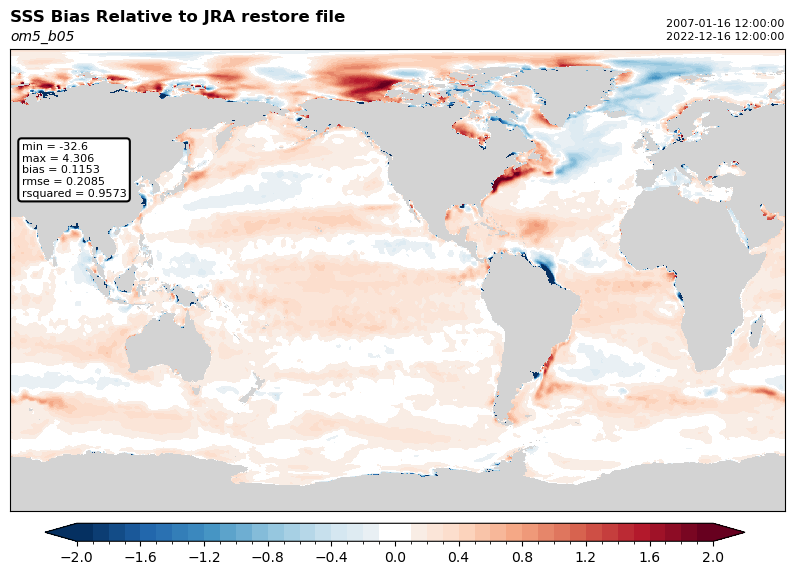

In [19]:
# Setup plot
fig = plt.figure(figsize=(10,6))
ax = plt.subplot(1,1,1, facecolor="lightgray")

# Definie geolon and geolat for plotting (use corners!)
x = ds.geolon_c
y = ds.geolat_c

# Get colormap
cmap, norm, boundaries = gen_levs_and_cmap(-2,2.01,0.1)

# Run pcolormesh
cb = plt.pcolormesh(x,y,model.values-obs, cmap=cmap, norm=norm)

# Clean up figure and add labels
set_annotaions(ax)

# Add statistics
stats, stats_str = calculate_stats(model, obs, ds.areacello)
add_stats_box(ax, stats_str)

# Add colorbar
add_colorbar(fig, cb, boundaries)


### Arctic

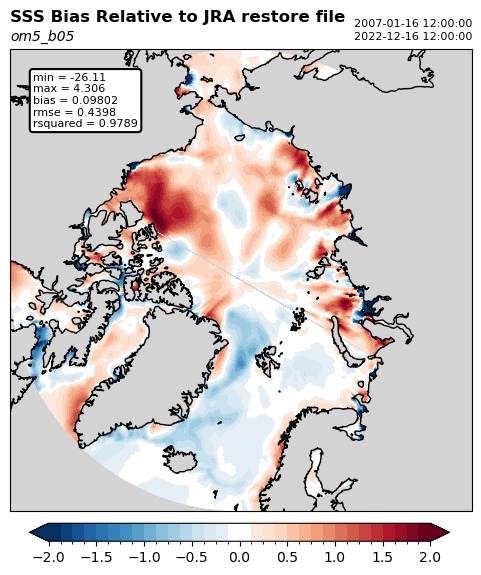

In [20]:
xrange = (-298,61)
yrange = (60.,91.)

_model = momgrid.geoslice.geoslice(model,x=xrange,y=yrange)
_obs = momgrid.geoslice.geoslice(obs,x=xrange,y=yrange,xcoord='lon',ycoord='lat')

xq = list((_model.xh.values - 0.5).astype(int))
yq = list((_model.yh.values - 0.5).astype(int))

xq = xq + [xq[-1] + 1]
yq = yq + [yq[-1] + 1]

x = ds.geolon_c.values[yq,:][:,xq]
y = ds.geolat_c.values[yq,:][:,xq]

# Get colormap
cmap, norm, boundaries = gen_levs_and_cmap(-2.0,2.125,0.125)

fig = plt.figure(figsize=(6,6))
ax = plt.subplot(1,1,1, facecolor="lightgray", projection=ccrs.NorthPolarStereo())
cb = ax.pcolormesh(x,y,_model-_obs,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.coastlines()

# Clean up figure and add labels
set_annotaions(ax)

# Add statistics
stats, stats_str = calculate_stats(_model, _obs, _model.areacello)
add_stats_box(ax, stats_str, x=0.05, y=0.95)

# Add colorbar
add_colorbar(fig, cb, boundaries)



### Southern Ocean

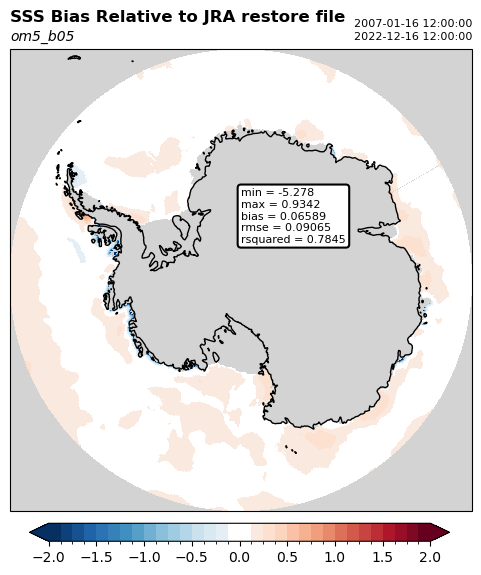

In [21]:
xrange = (-300,60)
yrange = (-60.,-91.)

_model = momgrid.geoslice.geoslice(model,x=xrange,y=yrange)
_obs = momgrid.geoslice.geoslice(obs,x=xrange,y=yrange,xcoord='lon',ycoord='lat')

xq = list((_model.xh.values - 0.5).astype(int))
yq = list((_model.yh.values - 0.5).astype(int))

xq = xq + [xq[-1] + 1]
yq = yq + [yq[-1] + 1]

x = ds.geolon_c.values[yq,:][:,xq]
y = ds.geolat_c.values[yq,:][:,xq]

# Get colormap
cmap, norm, boundaries = gen_levs_and_cmap(-2.0,2.125,0.125)

fig = plt.figure(figsize=(6,6))
ax = plt.subplot(1,1,1, facecolor="lightgray", projection=ccrs.SouthPolarStereo())
cb = ax.pcolormesh(x,y,_model-_obs,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.coastlines()

# Clean up figure and add labels
set_annotaions(ax)

# Add statistics
stats, stats_str = calculate_stats(_model, _obs, _model.areacello)
add_stats_box(ax, stats_str, x=0.5, y=0.7)

# Add colorbar
add_colorbar(fig, cb, boundaries)


### Northwest Pacific

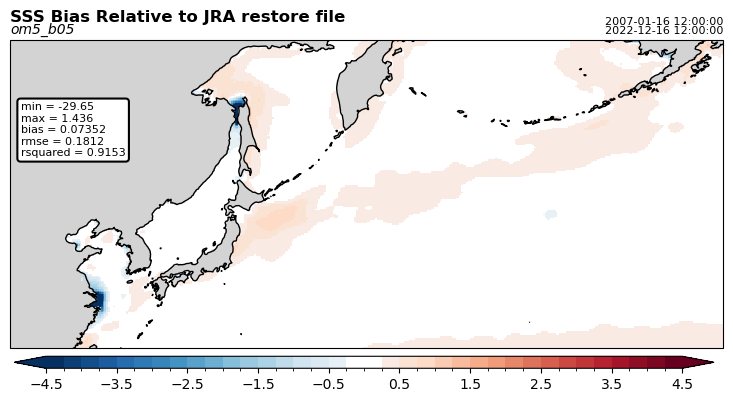

In [22]:
xrange = (-250.,-150.)
yrange = (25.,60.)

_model = momgrid.geoslice.geoslice(model,x=xrange,y=yrange)
_obs = momgrid.geoslice.geoslice(obs,x=xrange,y=yrange,xcoord='lon',ycoord='lat')

xq = list((_model.xh.values - 0.5).astype(int))
yq = list((_model.yh.values - 0.5).astype(int))

xq = xq + [xq[-1] + 1]
yq = yq + [yq[-1] + 1]

x = ds.geolon_c.values[yq,:][:,xq]
y = ds.geolat_c.values[yq,:][:,xq]

# Get colormap
cmap, norm, boundaries = gen_levs_and_cmap(-4.5,4.75,0.25)

fig = plt.figure(figsize=(10,4))
ax = plt.subplot(1,1,1, facecolor="lightgray", projection=ccrs.Miller(central_longitude=-200))
cb = ax.pcolormesh(x,y,_model-_obs,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.coastlines()

# Clean up figure and add labels
set_annotaions(ax)

# Add statistics
stats, stats_str = calculate_stats(_model, _obs, _model.areacello)
add_stats_box(ax, stats_str)

# Add colorbar
add_colorbar(fig, cb, boundaries)


### Tropical and Subtropical Indo-Pacific

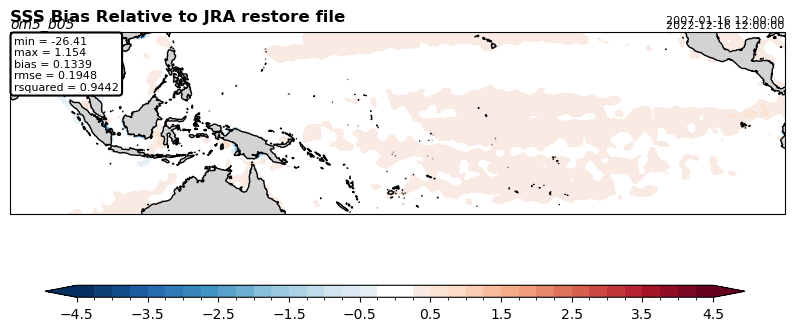

In [23]:
xrange = (-280.,-80.)
yrange = (-23.,23.)

_model = momgrid.geoslice.geoslice(model,x=xrange,y=yrange)
_obs = momgrid.geoslice.geoslice(obs,x=xrange,y=yrange,xcoord='lon',ycoord='lat')

xq = list((_model.xh.values - 0.5).astype(int))
yq = list((_model.yh.values - 0.5).astype(int))

xq = xq + [xq[-1] + 1]
yq = yq + [yq[-1] + 1]

x = ds.geolon_c.values[yq,:][:,xq]
y = ds.geolat_c.values[yq,:][:,xq]

# Get colormap
cmap, norm, boundaries = gen_levs_and_cmap(-4.5,4.75,0.25)

fig = plt.figure(figsize=(10,4))
ax = plt.subplot(1,1,1, facecolor="lightgray", projection=ccrs.Miller(central_longitude=-180))
cb = ax.pcolormesh(x,y,_model-_obs,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.coastlines()

# Clean up figure and add labels
set_annotaions(ax)

# Add statistics
stats, stats_str = calculate_stats(_model, _obs, _model.areacello)
add_stats_box(ax, stats_str, x=0.005, y=0.98)

# Add colorbar
add_colorbar(fig, cb, boundaries)


### South Indo-Pacific

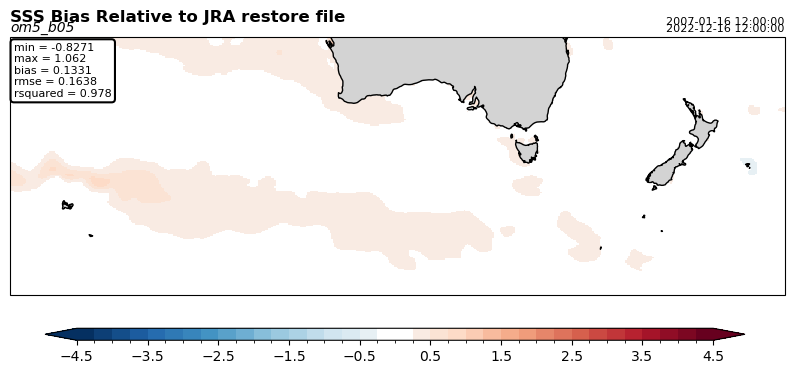

In [24]:
xrange = (-300.,-170.)
yrange = (-25.,-60.)

_model = momgrid.geoslice.geoslice(model,x=xrange,y=yrange)
_obs = momgrid.geoslice.geoslice(obs,x=xrange,y=yrange,xcoord='lon',ycoord='lat')

xq = list((_model.xh.values - 0.5).astype(int))
yq = list((_model.yh.values - 0.5).astype(int))

xq = xq + [xq[-1] + 1]
yq = yq + [yq[-1] + 1]

x = ds.geolon_c.values[yq,:][:,xq]
y = ds.geolat_c.values[yq,:][:,xq]

# Get colormap
cmap, norm, boundaries = gen_levs_and_cmap(-4.5,4.75,0.25)

fig = plt.figure(figsize=(10,4))
ax = plt.subplot(1,1,1, facecolor="lightgray", projection=ccrs.Miller(central_longitude=-180))
cb = ax.pcolormesh(x,y,_model-_obs,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.coastlines()

# Clean up figure and add labels
set_annotaions(ax)

# Add statistics
stats, stats_str = calculate_stats(_model, _obs, _model.areacello)
add_stats_box(ax, stats_str, x=0.005, y=0.98)

# Add colorbar
add_colorbar(fig, cb, boundaries)



### North Atlantic 

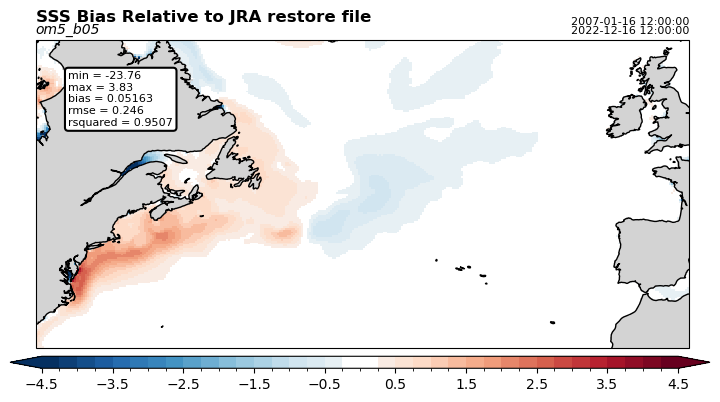

In [25]:
xrange = (-80.,-0.)
yrange = (30.,60.)

_model = momgrid.geoslice.geoslice(model,x=xrange,y=yrange)
_obs = momgrid.geoslice.geoslice(obs,x=xrange,y=yrange,xcoord='lon',ycoord='lat')

xq = list((_model.xh.values - 0.5).astype(int))
yq = list((_model.yh.values - 0.5).astype(int))

xq = xq + [xq[-1] + 1]
yq = yq + [yq[-1] + 1]

x = ds.geolon_c.values[yq,:][:,xq]
y = ds.geolat_c.values[yq,:][:,xq]

# Get colormap
cmap, norm, boundaries = gen_levs_and_cmap(-4.5,4.75,0.25)

fig = plt.figure(figsize=(10,4))
ax = plt.subplot(1,1,1, facecolor="lightgray", projection=ccrs.Miller(central_longitude=-60))
cb = ax.pcolormesh(x,y,_model-_obs,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.coastlines()

# Clean up figure and add labels
set_annotaions(ax)

# Add statistics
stats, stats_str = calculate_stats(_model, _obs, _model.areacello)
add_stats_box(ax, stats_str, x=0.05, y=0.9)

# Add colorbar
add_colorbar(fig, cb, boundaries)



### South Atlantic

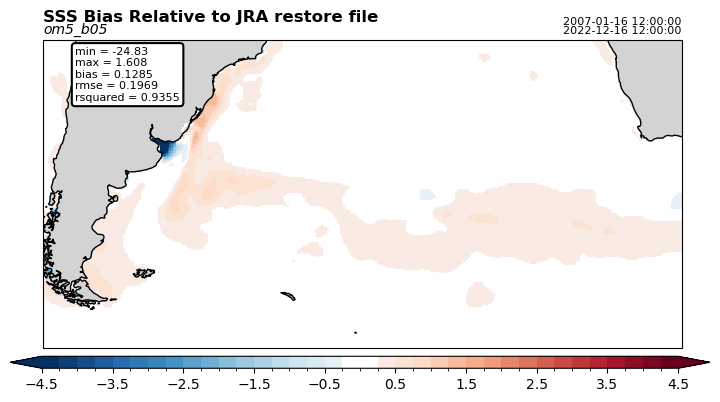

In [26]:
xrange = (-75.,25.)
yrange = (-20.,-60.)

_model = momgrid.geoslice.geoslice(model,x=xrange,y=yrange)
_obs = momgrid.geoslice.geoslice(obs,x=xrange,y=yrange,xcoord='lon',ycoord='lat')

xq = list((_model.xh.values - 0.5).astype(int))
yq = list((_model.yh.values - 0.5).astype(int))

xq = xq + [xq[-1] + 1]
yq = yq + [yq[-1] + 1]

x = ds.geolon_c.values[yq,:][:,xq]
y = ds.geolat_c.values[yq,:][:,xq]

# Get colormap
cmap, norm, boundaries = gen_levs_and_cmap(-4.5,4.75,0.25)

fig = plt.figure(figsize=(10,4))
ax = plt.subplot(1,1,1, facecolor="lightgray", projection=ccrs.Miller(central_longitude=-25))
cb = ax.pcolormesh(x,y,_model-_obs,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.coastlines()

# Clean up figure and add labels
set_annotaions(ax)

# Add statistics
stats, stats_str = calculate_stats(_model, _obs, _model.areacello)
add_stats_box(ax, stats_str, x=0.05, y=0.98)

# Add colorbar
add_colorbar(fig, cb, boundaries)


### California Current

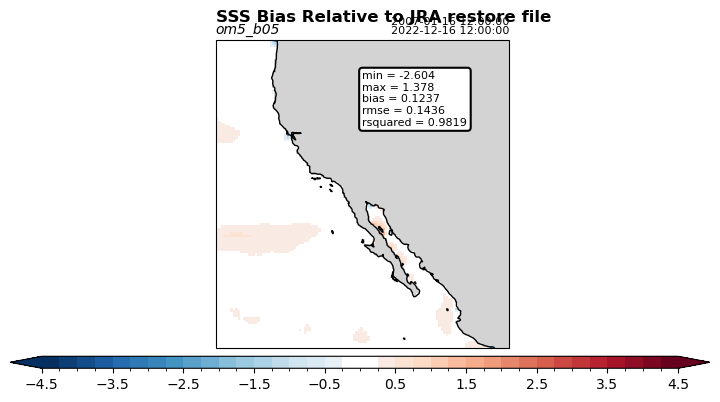

In [27]:
xrange = (-130.,-100.)
yrange = (18.,46.)

_model = momgrid.geoslice.geoslice(model,x=xrange,y=yrange)
_obs = momgrid.geoslice.geoslice(obs,x=xrange,y=yrange,xcoord='lon',ycoord='lat')

xq = list((_model.xh.values - 0.5).astype(int))
yq = list((_model.yh.values - 0.5).astype(int))

xq = xq + [xq[-1] + 1]
yq = yq + [yq[-1] + 1]

x = ds.geolon_c.values[yq,:][:,xq]
y = ds.geolat_c.values[yq,:][:,xq]

# Get colormap
cmap, norm, boundaries = gen_levs_and_cmap(-4.5,4.75,0.25)

fig = plt.figure(figsize=(10,4))
ax = plt.subplot(1,1,1, facecolor="lightgray", projection=ccrs.Miller(central_longitude=-115))
cb = ax.pcolormesh(x,y,_model-_obs,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.coastlines()

# Clean up figure and add labels
set_annotaions(ax)

# Add statistics
stats, stats_str = calculate_stats(_model, _obs, _model.areacello)
add_stats_box(ax, stats_str, x=0.5, y=0.9)

# Add colorbar
add_colorbar(fig, cb, boundaries)


### Bengula Current

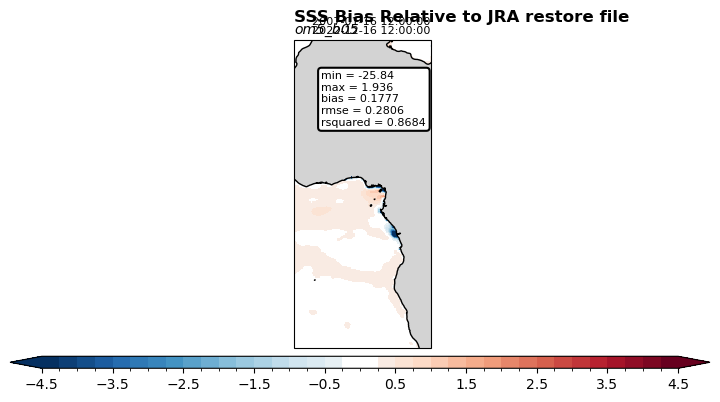

In [28]:
xrange = (-10.,20.)
yrange = (35.,-30.)

_model = momgrid.geoslice.geoslice(model,x=xrange,y=yrange)
_obs = momgrid.geoslice.geoslice(obs,x=xrange,y=yrange,xcoord='lon',ycoord='lat')

xq = list((_model.xh.values - 0.5).astype(int))
yq = list((_model.yh.values - 0.5).astype(int))

xq = xq + [xq[-1] + 1]
yq = yq + [yq[-1] + 1]

x = ds.geolon_c.values[yq,:][:,xq]
y = ds.geolat_c.values[yq,:][:,xq]

# Get colormap
cmap, norm, boundaries = gen_levs_and_cmap(-4.5,4.75,0.25)

fig = plt.figure(figsize=(10,4))
ax = plt.subplot(1,1,1, facecolor="lightgray", projection=ccrs.Miller(central_longitude=5))
cb = ax.pcolormesh(x,y,_model-_obs,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.coastlines()

# Clean up figure and add labels
set_annotaions(ax)

# Add statistics
stats, stats_str = calculate_stats(_model, _obs, _model.areacello)
add_stats_box(ax, stats_str, x=0.2, y=0.9)

# Add colorbar
add_colorbar(fig, cb, boundaries)


### Off the west coast of South America

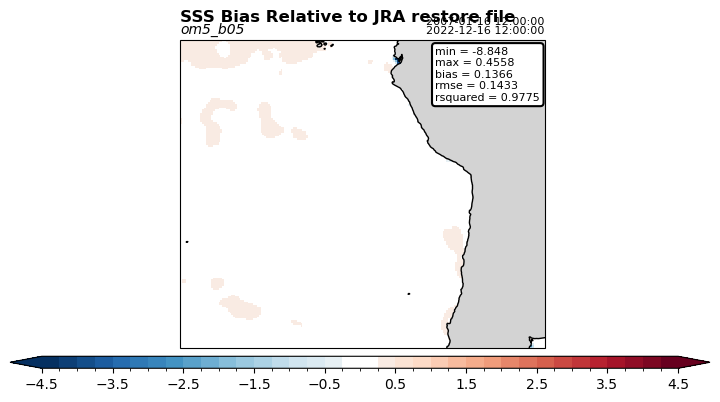

In [29]:
xrange = (-110.,-60.)
yrange = (0.,-40.)

_model = momgrid.geoslice.geoslice(model,x=xrange,y=yrange)
_obs = momgrid.geoslice.geoslice(obs,x=xrange,y=yrange,xcoord='lon',ycoord='lat')

xq = list((_model.xh.values - 0.5).astype(int))
yq = list((_model.yh.values - 0.5).astype(int))

xq = xq + [xq[-1] + 1]
yq = yq + [yq[-1] + 1]

x = ds.geolon_c.values[yq,:][:,xq]
y = ds.geolat_c.values[yq,:][:,xq]

# Get colormap
cmap, norm, boundaries = gen_levs_and_cmap(-4.5,4.75,0.25)

fig = plt.figure(figsize=(10,4))
ax = plt.subplot(1,1,1, facecolor="lightgray", projection=ccrs.Miller(central_longitude=-85))
cb = ax.pcolormesh(x,y,_model-_obs,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.coastlines()

# Clean up figure and add labels
set_annotaions(ax)

# Add statistics
stats, stats_str = calculate_stats(_model, _obs, _model.areacello)
add_stats_box(ax, stats_str, x=0.7, y=0.98)

# Add colorbar
add_colorbar(fig, cb, boundaries)



### Carribbean region

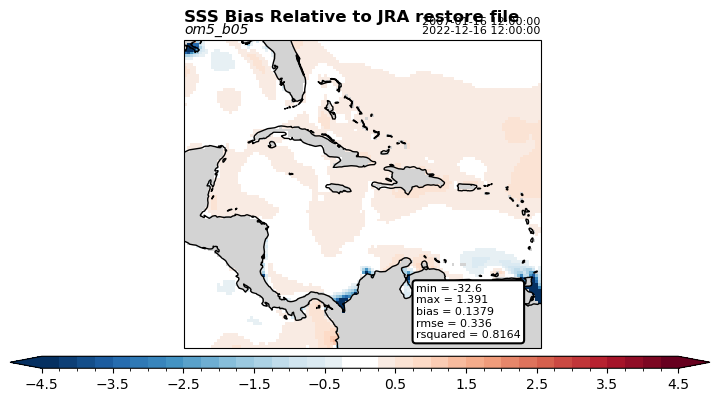

In [30]:
xrange = (-90.,-60.)
yrange = (5.,30.)

_model = momgrid.geoslice.geoslice(model,x=xrange,y=yrange)
_obs = momgrid.geoslice.geoslice(obs,x=xrange,y=yrange,xcoord='lon',ycoord='lat')

xq = list((_model.xh.values - 0.5).astype(int))
yq = list((_model.yh.values - 0.5).astype(int))

xq = xq + [xq[-1] + 1]
yq = yq + [yq[-1] + 1]

x = ds.geolon_c.values[yq,:][:,xq]
y = ds.geolat_c.values[yq,:][:,xq]

# Get colormap
cmap, norm, boundaries = gen_levs_and_cmap(-4.5,4.75,0.25)

fig = plt.figure(figsize=(10,4))
ax = plt.subplot(1,1,1, facecolor="lightgray", projection=ccrs.Miller(central_longitude=-60))
cb = ax.pcolormesh(x,y,_model-_obs,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.coastlines()

# Clean up figure and add labels
set_annotaions(ax)

# Add statistics
stats, stats_str = calculate_stats(_model, _obs, _model.areacello)
add_stats_box(ax, stats_str, x=0.65, y=0.21)

# Add colorbar
add_colorbar(fig, cb, boundaries)

